In [89]:
# !pip install seaborn


In [90]:
import matplotlib.pyplot

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

RANDOM_STATE = 8420

## **Modelling of Vietnam Dataset**

In [92]:
vietnam_path = "dataset/data_vietnam.npz"

In [93]:
# Load arrays from the .npz file
vietnam_data = np.load(vietnam_path)

# Access individual arrays
x_vietnam = vietnam_data['x']
y_classification_vietnam = vietnam_data['y_classification']
y_regression_vietnam = vietnam_data['y_regression']
columns_vietnam = vietnam_data['columns']


### **Classification Task**

In [94]:
x = x_vietnam
y = y_classification_vietnam
y = y.reshape(-1, )

In [95]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = RANDOM_STATE, shuffle = True)


#### **Classification Metrics**

##### **ROC Curve**

In [96]:
def roc_curve(y_true, y_pred):
    """
    Compute the Receiver Operating Characteristic (ROC) curve.

    Parameters:
        y_true (array-like): Ground truth binary labels (0 or 1).
        y_pred (array-like): Predicted probabilities or scores.

    Returns:
        fpr (array): False Positive Rate (FPR) values.
        tpr (array): True Positive Rate (TPR) values.
        thresholds (array): Threshold values.
    """
    # Convert y_pred to numpy array if it's not already
    y_pred = np.asarray(y_pred)

    # Sort predictions and true labels by predicted probabilities
    sorted_indices = np.argsort(y_pred)[::-1]
    y_pred_sorted = y_pred[sorted_indices]
    y_true_sorted = np.asarray(y_true)[sorted_indices]

    # Initialize arrays to store true positive rate (TPR), false positive rate (FPR), and thresholds
    tpr = np.zeros(len(y_pred) + 1)
    fpr = np.zeros(len(y_pred) + 1)
    thresholds = np.zeros(len(y_pred) + 1)

    # Initialize counts for true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN)
    TP = 0
    FP = 0
    TN = np.sum(y_true == 0)
    FN = np.sum(y_true == 1)

    # Initialize previous probability
    prev_prob = -np.inf

    # Compute TPR, FPR, and thresholds
    for i, prob in enumerate(np.concatenate([[prev_prob], y_pred_sorted])):
        tpr[i] = TP / (TP + FN)
        fpr[i] = FP / (FP + TN)
        thresholds[i] = prob

        # Update counts
        if i < len(y_pred):
            if y_true_sorted[i] == 1:
                TP += 1
                FN -= 1
            else:
                FP += 1
                TN -= 1

        # Update previous probability
        prev_prob = prob

    return fpr, tpr, thresholds


##### **AUC Score**

In [97]:
def auc(fpr, tpr):
    """
    Calculate the Area Under the Receiver Operating Characteristic (ROC) Curve (AUC).

    Parameters:
        fpr (array): False Positive Rate (FPR) values.
        tpr (array): True Positive Rate (TPR) values.

    Returns:
        float: Area under the ROC curve.
    """
    # Sort FPR and TPR arrays by increasing FPR
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    # Calculate area under the ROC curve using trapezoidal rule
    area = np.trapz(tpr_sorted, fpr_sorted)

    return area


In [98]:
# fpr, tpr, _ = roc_curve(y_true, y_pred)
# roc_auc = auc(fpr, tpr)

# print("FPR:", fpr)
# print("TPR:", tpr)
# print("AUC:", roc_auc)

##### **Taylor Diagram**

In [99]:
def taylor_diagram(y_true, y_pred, label_true='Ground Truth', label_pred='Predicted'):
    """
    Generate a Taylor diagram for comparing two datasets.

    Parameters:
        y_true (array-like): Ground truth values.
        y_pred (array-like): Predicted values.
        label_true (str): Label for the ground truth dataset.
        label_pred (str): Label for the predicted dataset.
    """
    # Compute statistics
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    rmse = np.sqrt(np.mean((y_pred - y_true)**2))
    std_ratio = np.std(y_pred) / np.std(y_true)

    # Create Taylor diagram
    plt.figure(figsize=(8, 8))
    plt.plot(1, corr, marker='o', markersize=10, label='Correlation', color='blue')
    plt.plot(np.sqrt(corr**2 + (1 - corr**2) * std_ratio**2), rmse, marker='o', markersize=10, label='RMSE', color='green')
    plt.plot(std_ratio, 0, marker='o', markersize=10, label='Standard deviation ratio', color='red')
    
    # Add reference lines
    plt.plot([0, 1], [0, 0], '--', color='gray', linewidth=0.5)
    plt.plot([0, 0], [0, rmse], '--', color='gray', linewidth=0.5)
    plt.plot([1, 1], [0, np.sqrt(2*rmse**2)], '--', color='gray', linewidth=0.5)

    # Add labels and legend
    plt.text(1.05, corr, label_true, verticalalignment='center')
    plt.text(np.sqrt(corr**2 + (1 - corr**2) * std_ratio**2), rmse, label_pred, verticalalignment='center')
    plt.text(std_ratio, 0, '1', verticalalignment='center')
    plt.xlabel('Standard deviation ratio')
    plt.ylabel('Correlation / RMSE')
    plt.title('Taylor Diagram')
    plt.legend()
    plt.grid(True)
    plt.show()


In [100]:
# # Example usage:
# y_true = np.array([0, 1, 0, 1, 0, 1])
# y_pred = np.array([0.2, 0.8, 0.3, 0.6, 0.4, 0.9])

# taylor_diagram(y_true, y_pred)

##### **Violin Plot**

In [101]:
def violin_plot(y_true, y_pred, labels=['Ground Truth', 'Predicted']):
    """
    Generate a violin plot for comparing two datasets.

    Parameters:
        y_true (array-like): Ground truth values.
        y_pred (array-like): Predicted values.
        labels (list): Labels for the datasets.
    """
    # Combine the datasets into a single DataFrame
    data = {'Values': np.concatenate([y_true, y_pred]),
            'Dataset': np.repeat(labels, [len(y_true), len(y_pred)])}
    df = pd.DataFrame(data)

    # Create violin plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Dataset', y='Values', data=df)
    plt.xlabel('Dataset')
    plt.ylabel('Values')
    plt.title('Violin Plot')
    plt.show()


In [102]:
# # Example usage:
# y_true = np.array([0, 1, 0, 1, 0, 1])
# y_pred = np.array([0.2, 0.8, 0.3, 0.6, 0.4, 0.9])

# violin_plot(y_true, y_pred)

#### **Classification Models**

##### **ANN**

##### **Logistic Regression**

In [103]:
from sklearn.linear_model import LogisticRegression


In [104]:
# Create and fit the logistic regression model
model = LogisticRegression()
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


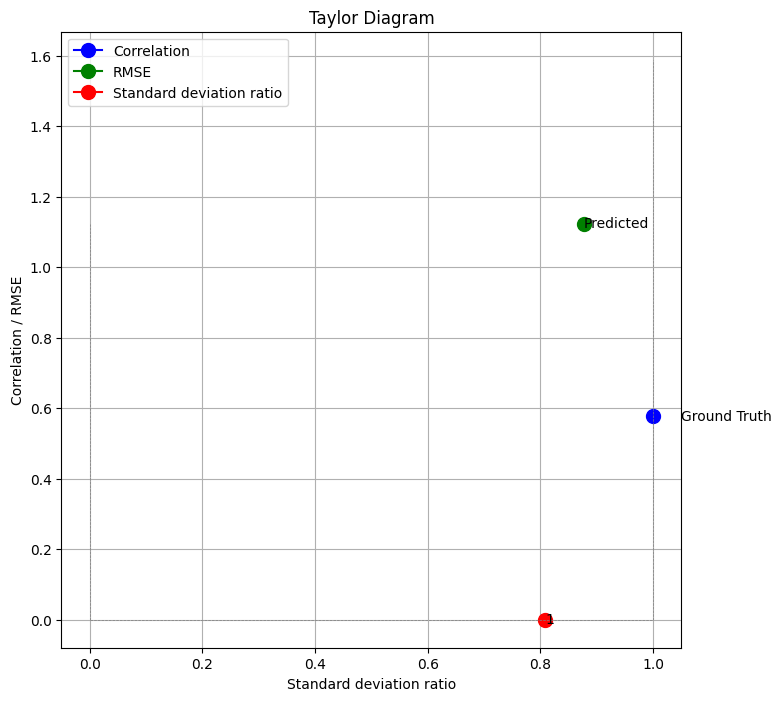

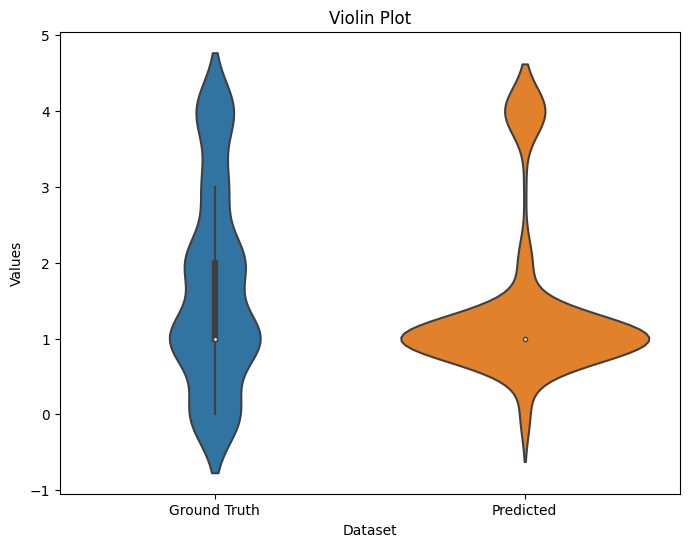

In [105]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
taylor_diagram(y_test, y_pred)
violin_plot(y_test, y_pred)

##### **Support Vector Machine**

In [106]:
from sklearn.svm import SVC

In [107]:
# Create and fit the Support Vector Classifier model
model = SVC()
model.fit(x_train, y_train)

SVC()

In [108]:
# Make predictions on the test set
y_pred = model.predict(x_test)

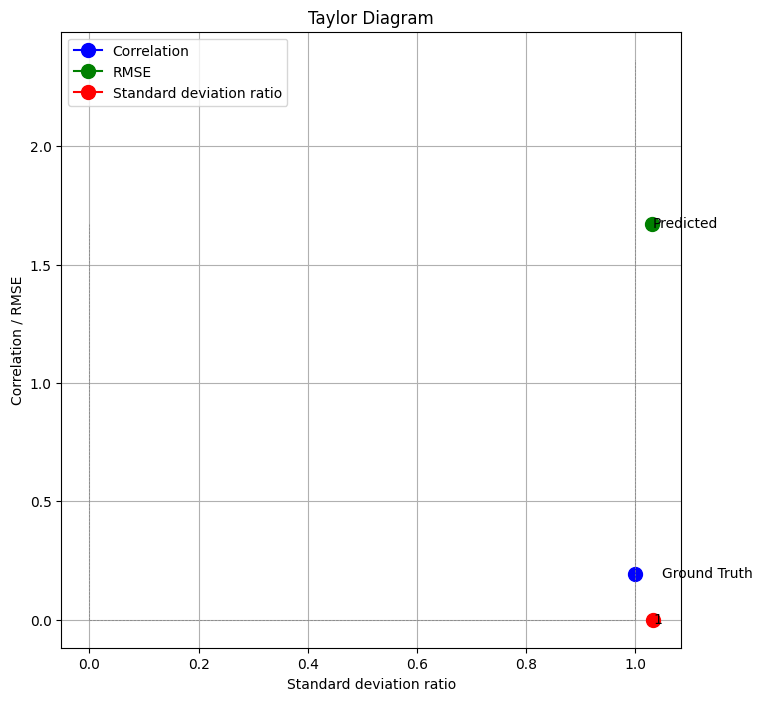

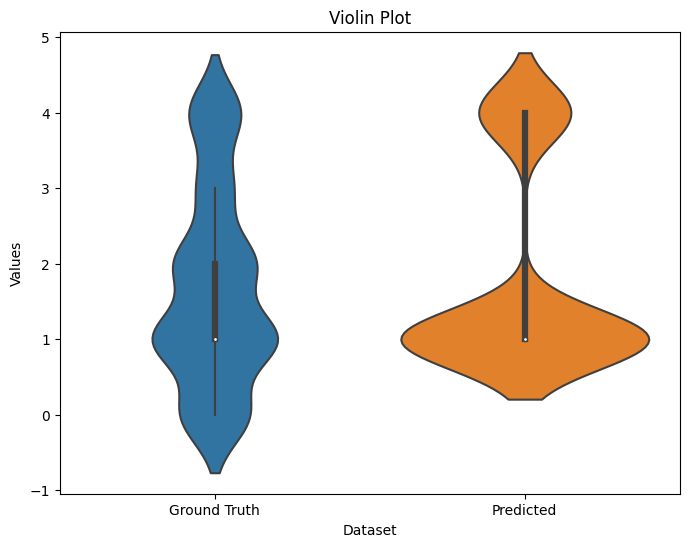

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
taylor_diagram(y_test, y_pred)
violin_plot(y_test, y_pred)

In [110]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3177570093457944


##### **Decision Tree**

In [111]:
from sklearn.tree import DecisionTreeClassifier

In [112]:
# Create and fit the Decision Tree Classifier model
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [113]:
# Make predictions on the test set
y_pred = model.predict(x_test)


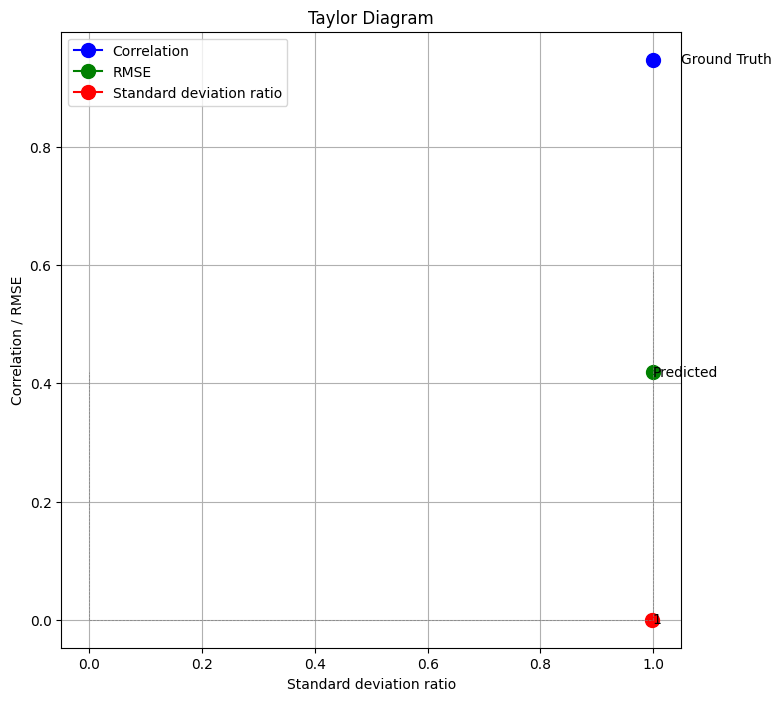

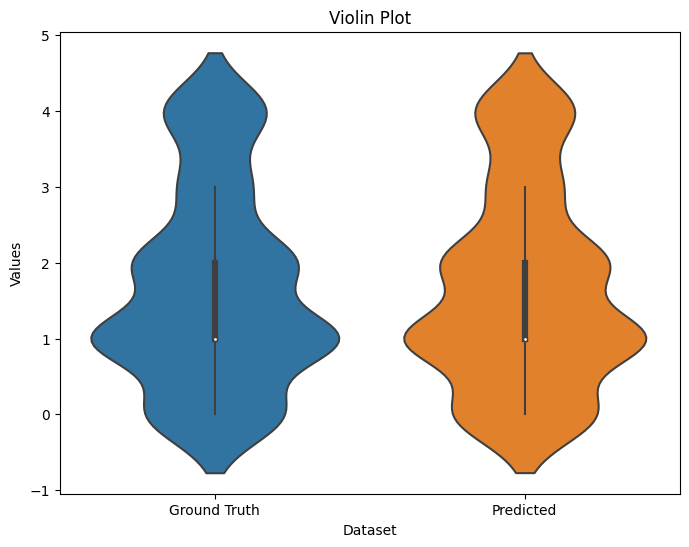

In [114]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
taylor_diagram(y_test, y_pred)
violin_plot(y_test, y_pred)

In [115]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8317757009345794


##### **Random Forest**

In [116]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
# Create and fit the Random Forest Classifier model
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [118]:
# Make predictions on the test set
y_pred = model.predict(x_test)

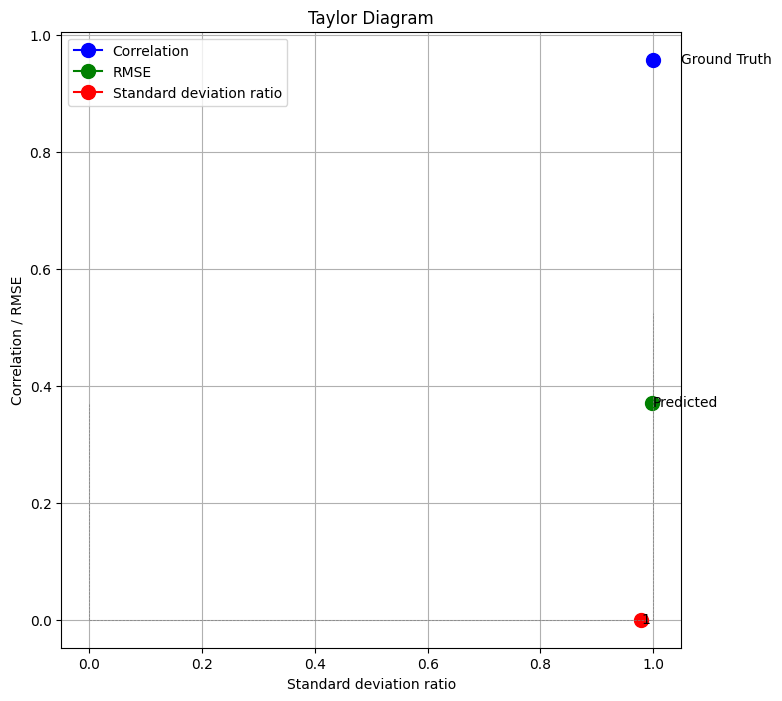

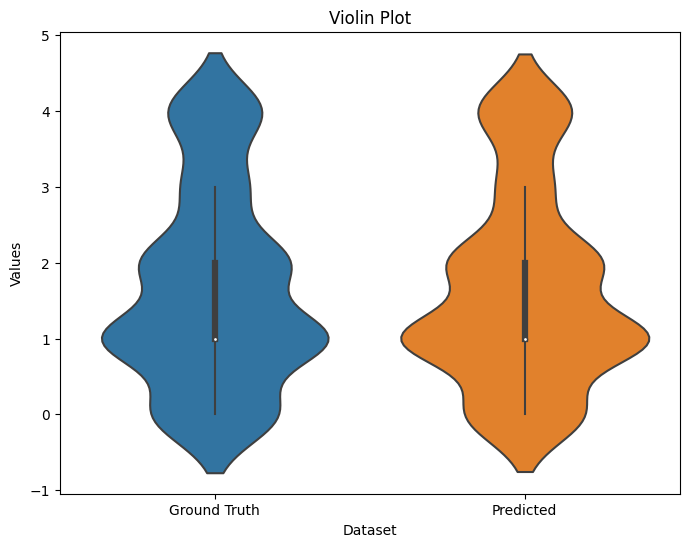

In [119]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
taylor_diagram(y_test, y_pred)
violin_plot(y_test, y_pred)

In [120]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8621495327102804


##### **XGBoost**

In [121]:
import xgboost as xgb

In [122]:
# Create and fit the XGBoost classifier model
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [123]:
# Make predictions on the test set
y_pred = model.predict(x_test)

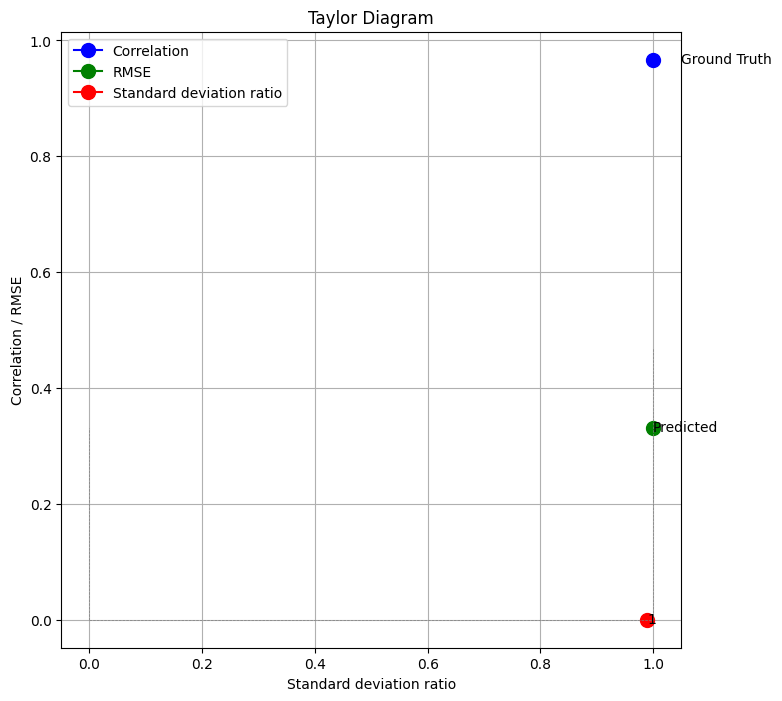

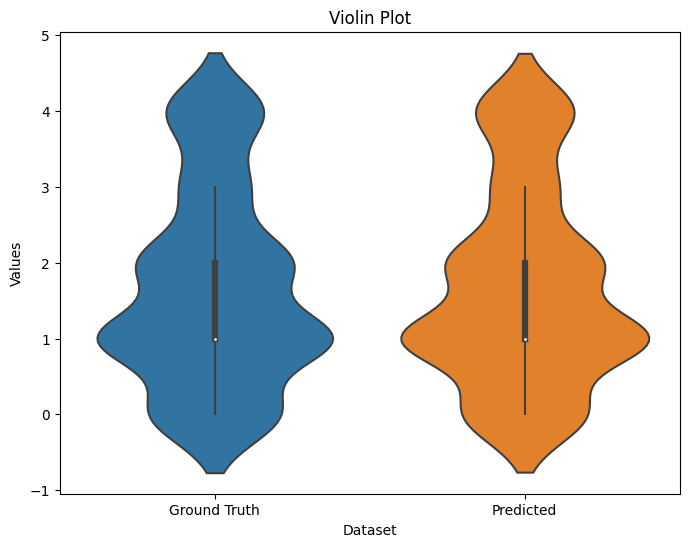

In [124]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
taylor_diagram(y_test, y_pred)
violin_plot(y_test, y_pred)

In [125]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8901869158878505


##### **LightGBM**

In [126]:
import lightgbm as lgb

In [127]:
# Create and fit the LightGBM classifier model
model = lgb.LGBMClassifier()
model.fit(x_train, y_train)

LGBMClassifier()

In [128]:
# Make predictions on the test set
y_pred = model.predict(x_test)

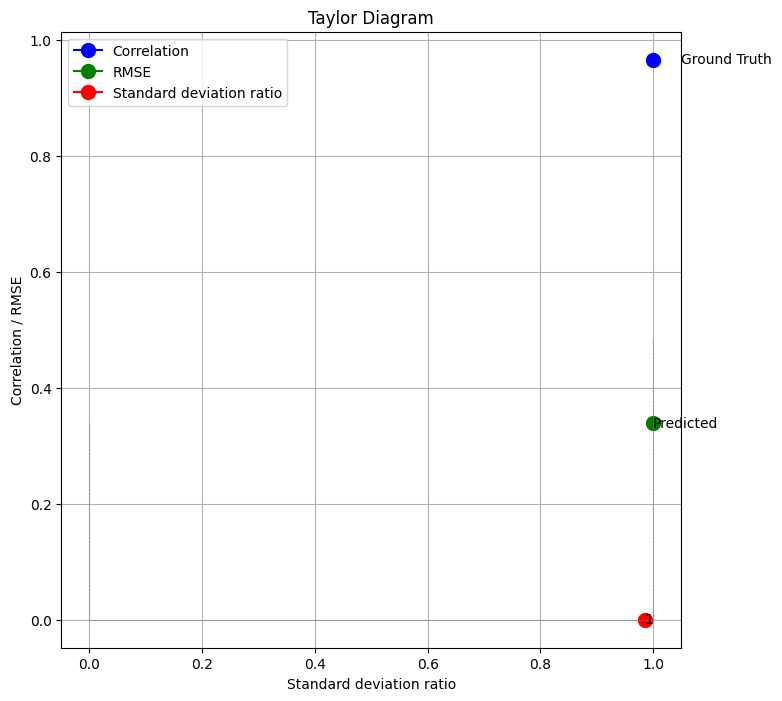

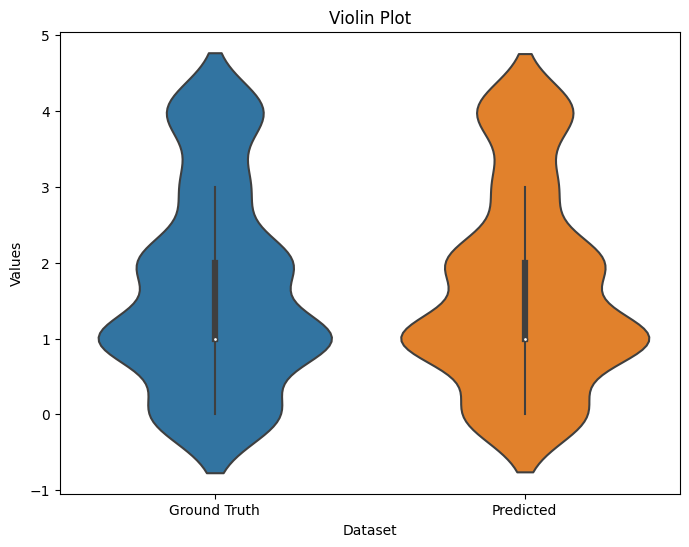

In [129]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
taylor_diagram(y_test, y_pred)
violin_plot(y_test, y_pred)

In [130]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8855140186915887


##### **LightGBM + Bayesian Optimization**

In [131]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score

In [132]:
# Define the LightGBM objective function to optimize
def lgbm_cv(num_leaves, max_depth, learning_rate, subsample, colsample_bytree, reg_alpha, reg_lambda):
    params = {
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'objective': 'multiclass',
        'num_class': len(set(y)),  # Number of classes
        'metric': 'multi_logloss',  # Use multi_logloss for multiclass
        'verbosity': -1,
        'n_jobs': -1
    }

    # Create LightGBM dataset
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)

    # Train the model with the given parameters
    model = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=[dval], verbose_eval=False)

    # Predict probabilities on validation set
    y_pred_proba = model.predict(x_test)

    # Predict classes
    y_pred = y_pred_proba.argmax(axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [133]:
# Define parameter bounds for optimization
pbounds = {
    'num_leaves': (20, 100),
    'max_depth': (5, 15),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1)
}

In [134]:
# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

In [135]:
# Perform Bayesian Optimization
optimizer.maximize(init_points=5, n_iter=10)


|   iter    |  target   | colsam... | learni... | max_depth | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 1         | 0.8879    | 0.6873    | 0.2857    | 12.32     | 67.89     | 0.156     | 0.156     | 0.529     |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 2         | 0.9136    | 0.9331    | 0.1843    | 12.08     | 21.65     | 0.9699    | 0.8324    | 0.6062    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 3         | 0.8902    | 0.5909    | 0.06319   | 8.042     | 61.98     | 0.4319    | 0.2912    | 0.8059    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 4         | 0.8879    | 0.5697    | 0.09472   | 8.664     | 56.49     | 0.7852    | 0.1997    | 0.7571    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 5         | 0.9019    | 0.7962    | 0.02347   | 11.08     | 33.64     | 0.06505   | 0.9489    | 0.9828    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 6         | 0.8785    | 0.5       | 0.3       | 5.0       | 20.0      | 1.0       | 0.0       | 0.5       |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 7         | 0.8949    | 0.9924    | 0.2851    | 11.87     | 21.47     | 0.1471    | 0.7598    | 0.8009    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 8         | 0.8855    | 0.8634    | 0.2258    | 12.04     | 21.75     | 0.85      | 0.4066    | 0.938     |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 9         | 0.8972    | 0.9993    | 0.02484   | 12.83     | 79.39     | 0.7924    | 0.3493    | 0.7322    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 10        | 0.8879    | 0.778     | 0.2721    | 11.62     | 38.44     | 0.9661    | 0.3961    | 0.5138    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 11        | 0.8995    | 0.9046    | 0.0659    | 13.51     | 72.08     | 0.6631    | 0.0512    | 0.7094    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 12        | 0.8879    | 0.8548    | 0.1931    | 13.02     | 73.91     | 0.8448    | 0.2156    | 0.98      |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 13        | 0.8785    | 0.5596    | 0.2856    | 14.68     | 96.27     | 0.9249    | 0.2364    | 0.7107    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 14        | 0.8879    | 0.9881    | 0.213     | 14.03     | 55.57     | 0.408     | 0.2404    | 0.5895    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 15        | 0.8972    | 0.7141    | 0.1049    | 10.18     | 98.51     | 0.01684   | 0.8906    | 0.7597    |


In [136]:
# Get the best hyperparameters
best_params = optimizer.max['params']
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 0.9330880728874675, 'learning_rate': 0.18432335340553055, 'max_depth': 12.080725777960454, 'num_leaves': 21.646759543664196, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 0.8324426408004217, 'subsample': 0.6061695553391381}


##### **LightGBM + Bayesian Optimization + K Fold Crossvalidation**

In [138]:
class LightGBMClassifierOptimizer:
    def __init__(self, X, y, n_folds=5):
        self.X = X
        self.y = y
        self.n_folds = n_folds
        self.best_params = {}

    def lgbm_cv(self, num_leaves, max_depth, learning_rate, subsample, colsample_bytree, reg_alpha, reg_lambda):
        params = {
            'num_leaves': int(num_leaves),
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'objective': 'binary',
            'metric': 'binary_error',
            'verbosity': -1,
            'n_jobs': -1
        }

        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        accuracies = []
        for train_idx, val_idx in kf.split(self.X):
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]

            dtrain = lgb.Dataset(X_train, label=y_train)
            dval = lgb.Dataset(X_val, label=y_val)

            model = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=[dval], verbose_eval=False)

            y_pred = model.predict(X_val)
            y_pred = np.round(y_pred)

            accuracy = accuracy_score(y_val, y_pred)
            accuracies.append(accuracy)

        return np.mean(accuracies)

    def optimize(self):
        pbounds = {
            'num_leaves': (20, 100),
            'max_depth': (5, 15),
            'learning_rate': (0.01, 0.3),
            'subsample': (0.5, 1),
            'colsample_bytree': (0.5, 1),
            'reg_alpha': (0, 1),
            'reg_lambda': (0, 1)
        }

        optimizer = BayesianOptimization(
            f=self.lgbm_cv,
            pbounds=pbounds,
            random_state=42,
            verbose=2
        )

        optimizer.maximize(init_points=5, n_iter=10)

        self.best_params = optimizer.max['params']

    def train(self):
        params = {
            'num_leaves': int(self.best_params['num_leaves']),
            'max_depth': int(self.best_params['max_depth']),
            'learning_rate': self.best_params['learning_rate'],
            'subsample': self.best_params['subsample'],
            'colsample_bytree': self.best_params['colsample_bytree'],
            'reg_alpha': self.best_params['reg_alpha'],
            'reg_lambda': self.best_params['reg_lambda'],
            'objective': 'binary',
            'metric': 'binary_error',
            'verbosity': -1,
            'n_jobs': -1
        }

        dtrain = lgb.Dataset(self.X, label=self.y)
        self.model = lgb.train(params, dtrain, num_boost_round=1000)

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred = np.round(y_pred)
        return y_pred

In [139]:
# Assuming you have your input data X and target variable y
X = x_vietnam
y = y_classification_vietnam


In [140]:
# Initialize the LightGBMClassifierOptimizer with input data and target variable
lgbm_optimizer = LightGBMClassifierOptimizer(X, y, n_folds=5)

In [141]:
# Optimize hyperparameters using Bayesian Optimization
lgbm_optimizer.optimize()

|   iter    |  target   | colsam... | learni... | max_depth | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 1         | 0.4951    | 0.6873    | 0.2857    | 12.32     | 67.89     | 0.156     | 0.156     | 0.529     |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 2         | 0.4979    | 0.9331    | 0.1843    | 12.08     | 21.65     | 0.9699    | 0.8324    | 0.6062    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 3         | 0.4984    | 0.5909    | 0.06319   | 8.042     | 61.98     | 0.4319    | 0.2912    | 0.8059    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 4         | 0.496     | 0.5697    | 0.09472   | 8.664     | 56.49     | 0.7852    | 0.1997    | 0.7571    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 5         | 0.4988    | 0.7962    | 0.02347   | 11.08     | 33.64     | 0.06505   | 0.9489    | 0.9828    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 6         | 0.496     | 0.6285    | 0.09907   | 10.98     | 33.75     | 0.1042    | 0.6789    | 0.8895    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 7         | 0.4951    | 0.5322    | 0.0416    | 13.96     | 88.0      | 0.7519    | 0.2789    | 0.7489    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 8         | 0.4984    | 0.7128    | 0.1088    | 14.05     | 57.8      | 0.9426    | 0.2972    | 0.8402    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 9         | 0.5002    | 0.9993    | 0.02484   | 12.83     | 79.39     | 0.7924    | 0.3493    | 0.7322    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 10        | 0.496     | 0.778     | 0.2721    | 11.62     | 38.44     | 0.9661    | 0.3961    | 0.5138    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 11        | 0.5012    | 0.9046    | 0.0659    | 13.51     | 72.08     | 0.6631    | 0.0512    | 0.7094    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 12        | 0.4993    | 0.8548    | 0.1931    | 13.02     | 73.91     | 0.8448    | 0.2156    | 0.98      |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 13        | 0.4927    | 0.5596    | 0.2856    | 14.68     | 96.27     | 0.9249    | 0.2364    | 0.7107    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 14        | 0.5021    | 0.9881    | 0.213     | 14.03     | 55.57     | 0.408     | 0.2404    | 0.5895    |


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Convert

| 15        | 0.497     | 0.7141    | 0.1049    | 10.18     | 98.51     | 0.01684   | 0.8906    | 0.7597    |


In [142]:
# Train the LightGBM model with the best hyperparameters
lgbm_optimizer.train()

C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [143]:
# Make predictions on new data
X_test = x_test  # Your new data
y_pred = lgbm_optimizer.predict(X_test)

In [144]:
import numpy as np

# Assuming arr is your NumPy array
arr = np.array([1, 2, 3, 4, 1, 2, 3, 4, 5])

# Get the unique values
unique_values = np.unique(arr)

print("Number of Unique values:", len(unique_values))

Number of Unique values: 5


##### **Ensemble + Bayesian Optimization + K-Fold Cross Validation + Voting Classifier**

In [58]:
from sklearn.ensemble import VotingClassifier

In [86]:
class EnsembleModel:
    def __init__(self, X, y, n_folds=5):
        self.X = X
        self.y = y
        self.n_folds = n_folds
        self.models = []

    def rf_cv(self, n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
        params = {
            "n_estimators": int(n_estimators),
            "max_depth": int(max_depth),
            "min_samples_split": int(min_samples_split),
            "min_samples_leaf": int(min_samples_leaf),
            "max_features": max_features,
            "random_state": 42
        }
            
        model = RandomForestClassifier(
            **params
            # n_estimators=int(n_estimators),
            # max_depth=int(max_depth),
            # min_samples_split=int(min_samples_split),
            # min_samples_leaf=int(min_samples_leaf),
            # max_features=max_features,
            # random_state=42
        )

        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        accuracies = []
        for train_idx, val_idx in kf.split(self.X):
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            accuracy = accuracy_score(y_val, y_pred)
            accuracies.append(accuracy)

        return np.mean(accuracies)

    def xgb_cv(self, max_depth, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda):
        params = {
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            'n_estimators': int(n_estimators),
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'objective': 'multi:softmax',  # for multiclass classification
            'num_class': len(np.unique(self.y)),
            'random_state': 42
        }

        model = xgb.XGBClassifier(**params)

        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        accuracies = []
        for train_idx, val_idx in kf.split(self.X):
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            accuracy = accuracy_score(y_val, y_pred)
            accuracies.append(accuracy)

        return np.mean(accuracies)

    def lgbm_cv(self, num_leaves, max_depth, learning_rate, subsample, colsample_bytree, reg_alpha, reg_lambda):
        params = {
            'num_leaves': int(num_leaves),
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'objective': 'multiclass',
            'num_class': len(np.unique(self.y)),
            'metric': 'multi_logloss',
            'verbosity': -1,
            'n_jobs': -1,
            'random_state': 42
        }

        model = lgb.LGBMClassifier(**params)

        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        accuracies = []
        for train_idx, val_idx in kf.split(self.X):
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            accuracy = accuracy_score(y_val, y_pred)
            accuracies.append(accuracy)

        return np.mean(accuracies)

    def optimize(self):
        pbounds_rf = {
            'n_estimators': (100, 1000),
            'max_depth': (5, 15),
            'min_samples_split': (2, 10),
            'min_samples_leaf': (1, 10),
            'max_features': (0.1, 1)
        }

        pbounds_xgb = {
            'max_depth': (3, 10),
            'learning_rate': (0.01, 0.3),
            'n_estimators': (100, 1000),
            'subsample': (0.5, 1),
            'colsample_bytree': (0.5, 1),
            'reg_alpha': (0, 1),
            'reg_lambda': (0, 1)
        }

        pbounds_lgbm = {
            'num_leaves': (20, 100),
            'max_depth': (5, 15),
            'learning_rate': (0.01, 0.3),
            'subsample': (0.5, 1),
            'colsample_bytree': (0.5, 1),
            'reg_alpha': (0, 1),
            'reg_lambda': (0, 1)
        }

        # Optimize Random Forest
        optimizer_rf = BayesianOptimization(
            f=self.rf_cv,
            pbounds=pbounds_rf,
            random_state=42,
            verbose=2
        )
        optimizer_rf.maximize(init_points=5, n_iter=5)

        # Optimize XGBoost
        optimizer_xgb = BayesianOptimization(
            f=self.xgb_cv,
            pbounds=pbounds_xgb,
            random_state=42,
            verbose=2
        )
        optimizer_xgb.maximize(init_points=5, n_iter=5)

        # Optimize LightGBM
        optimizer_lgbm = BayesianOptimization(
            f=self.lgbm_cv,
            pbounds=pbounds_lgbm,
            random_state=42,
            verbose=2
        )
        optimizer_lgbm.maximize(init_points=5, n_iter=5)
        
        rf_params = optimizer_rf.max['params']
        xgb_params = optimizer_xgb.max['params']
        lgbm_params = optimizer_lgbm.max['params']
        
        rf_params["max_depth"] = int(rf_params["max_depth"])
        xgb_params["max_depth"] = int(xgb_params["max_depth"])
        lgbm_params["max_depth"] = int(lgbm_params["max_depth"])
        
        rf_params["n_estimators"] = int(rf_params["n_estimators"])
        xgb_params["n_estimators"] = int(xgb_params["n_estimators"])
        lgbm_params["num_leaves"] = int(lgbm_params["num_leaves"])
        
        print("Random Forest Parameters")
        print(rf_params)
        
        print("XGBoost Parameters:")
        print(xgb_params)
        
        print("LightGBM Parameters:")
        print(lgbm_params)
        
        
        # Train models with best hyperparameters
        clf_rf = RandomForestClassifier(rf_params, random_state=42)
        clf_xgb = xgb.XGBClassifier(xgb_params, random_state=42)
        clf_lgbm = lgb.LGBMClassifier(lgbm_params, random_state=42)
        
        self.model_ensemble = VotingClassifier(estimators=[('RF', clf_rf), 
                                                            ('XGB', clf_xgb), 
                                                            ('LGBM', clf_lgbm)], 
                                               voting='hard')

    def train(self):
        self.model_ensemble.fit(self.X, self.y)

    def predict(self, X_test):
#         predictions = np.zeros((X_test.shape[0], len(self.models)))
#         for i, model in enumerate(self.models):
#             predictions[:, i] = model.predict(X_test)

#         # Voting Classifier
#         y_pred = np.mean(predictions, axis=1)
#         y_pred = np.round(y_pred).astype(int)
        y_pred = self.model_ensemble.predict(X_test)
        return y_pred

In [87]:
# Initialize the EnsembleModel
ensemble_model = EnsembleModel(x_vietnam, y_classification_vietnam)


In [88]:
# Optimize hyperparameters and train models
ensemble_model.optimize()
ensemble_model.train()


|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 1         | 0.877     | 8.745     | 0.9556    | 7.588     | 6.789     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 2         | 0.8387    | 6.56      | 0.2404    | 1.523     | 8.929     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 3         | 0.8943    | 11.01     | 0.7373    | 1.185     | 9.759     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 4         | 0.8873    | 13.32     | 0.2911    | 2.636     | 3.467     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 5         | 0.8934    | 8.042     | 0.5723    | 4.888     | 4.33      |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 6         | 0.8808    | 7.975     | 0.6261    | 4.957     | 4.418     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 7         | 0.7246    | 5.492     | 0.1166    | 6.405     | 7.791     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 8         | 0.7994    | 8.608     | 0.1233    | 4.309     | 3.598     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 9         | 0.9009    | 11.15     | 0.5583    | 1.489     | 9.087     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 10        | 0.8607    | 10.58     | 0.2175    | 1.848     | 9.536     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 11        | 0.8897    | 11.64     | 0.9935    | 1.0       | 9.21      |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 12        | 0.8911    | 10.69     | 0.9563    | 1.015     | 8.635     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 13        | 0.8537    | 11.44     | 0.1251    | 1.0       | 8.459     |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 14        | 0.892     | 11.17     | 1.0       | 2.01      | 8.57      |


C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23296\2815274789.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y

| 15        | 0.8929    | 11.64     | 1.0       | 1.98      | 9.56      |
|   iter    |  target   | colsam... | learni... | max_depth | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9051    | 0.6873    | 0.2857    | 8.124     | 0.5987    | 0.156     | 0.578     |
| 2         | 0.8929    | 0.529     | 0.2612    | 7.208     | 0.7081    | 0.02058   | 0.985     |
| 3         | 0.9084    | 0.9162    | 0.07158   | 4.273     | 0.1834    | 0.3042    | 0.7624    |
| 4         | 0.9037    | 0.716     | 0.09446   | 7.283     | 0.1395    | 0.2921    | 0.6832    |
| 5         | 0.9004    | 0.728     | 0.2377    | 4.398     | 0.5142    | 0.5924    | 0.5232    |
| 6         | 0.9051    | 0.8768    | 0.2587    | 7.131     | 0.3663    | 0.441     | 0.8931    |
| 7         | 0.8855    | 1.0       | 0.03125   | 4.282     | 0.1449    | 0.2211    | 0.7552    |
| 8         | 0.8976    | 0.6052    | 0.2978

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 1         | 0.8995    | 0.6873    | 0.2857    | 12.32     | 67.89     | 0.156     | 0.156     | 0.529     |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 2         | 0.9093    | 0.9331    | 0.1843    | 12.08     | 21.65     | 0.9699    | 0.8324    | 0.6062    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 3         | 0.8948    | 0.5909    | 0.06319   | 8.042     | 61.98     | 0.4319    | 0.2912    | 0.8059    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 4         | 0.8934    | 0.5697    | 0.09472   | 8.664     | 56.49     | 0.7852    | 0.1997    | 0.7571    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 5         | 0.8948    | 0.7962    | 0.02347   | 11.08     | 33.64     | 0.06505   | 0.9489    | 0.9828    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 6         | 0.9018    | 0.7234    | 0.0458    | 7.06      | 20.08     | 0.03927   | 0.9773    | 0.6212    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 7         | 0.9023    | 0.9691    | 0.2072    | 14.95     | 20.21     | 0.009253  | 0.06753   | 0.9718    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 8         | 0.8957    | 0.5577    | 0.2156    | 11.35     | 24.4      | 0.5473    | 0.2476    | 0.558     |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 9         | 0.8986    | 0.9993    | 0.02484   | 12.83     | 79.39     | 0.7924    | 0.3493    | 0.7322    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 10        | 0.899     | 0.778     | 0.2721    | 11.62     | 38.44     | 0.9661    | 0.3961    | 0.5138    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 11        | 0.9074    | 0.9046    | 0.0659    | 13.51     | 72.08     | 0.6631    | 0.0512    | 0.7094    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 12        | 0.8995    | 0.8548    | 0.1931    | 13.02     | 73.91     | 0.8448    | 0.2156    | 0.98      |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 13        | 0.8948    | 0.5596    | 0.2856    | 14.68     | 96.27     | 0.9249    | 0.2364    | 0.7107    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 14        | 0.906     | 0.675     | 0.1308    | 12.3      | 21.52     | 0.8583    | 0.7558    | 0.7148    |


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

| 15        | 0.9046    | 0.848     | 0.1973    | 11.45     | 22.3      | 0.891     | 0.6699    | 0.5479    |
Random Forest Parameters
{'max_depth': 11, 'max_features': 0.5582609827390705, 'min_samples_leaf': 1.4885738318633865, 'min_samples_split': 9.087226108724144}
XGBoost Parameters:
{'colsample_bytree': 0.8947922296626573, 'learning_rate': 0.16529758535906713, 'max_depth': 9, 'reg_alpha': 0.45735206398337214, 'reg_lambda': 0.4224654850649707, 'subsample': 0.8269132394467523}
LightGBM Parameters:
{'colsample_bytree': 0.9330880728874675, 'learning_rate': 0.18432335340553055, 'max_depth': 12, 'num_leaves': 21.646759543664196, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 0.8324426408004217, 'subsample': 0.6061695553391381}


InvalidParameterError: The 'n_estimators' parameter of RandomForestClassifier must be an int in the range [1, inf). Got {'max_depth': 11, 'max_features': 0.5582609827390705, 'min_samples_leaf': 1.4885738318633865, 'min_samples_split': 9.087226108724144} instead.

In [ ]:
# Make predictions on new data
y_pred = ensemble_model.predict(x_test)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
taylor_diagram(y_test, y_pred)
violin_plot(y_test, y_pred)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

### **Regression Task**

In [ ]:
x = x_vietnam
y = y_regression_vietnam
y = y.reshape(-1, )

In [ ]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = RANDOM_STATE, shuffle = True)


#### **Regression Metrics**

##### **R2 Score**

In [ ]:
def r2_score(y_true, y_pred):
    """
    Compute the R-squared (R2) score for regression task.

    Parameters:
        y_true (array-like): Ground truth values.
        y_pred (array-like): Predicted values.

    Returns:
        float: R-squared (R2) score.
    """
    # Convert input arrays to numpy arrays if they are not already
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Calculate mean of the true values
    mean_true = np.mean(y_true)

    # Calculate total sum of squares (TSS)
    tss = np.sum((y_true - mean_true) ** 2)

    # Calculate residual sum of squares (RSS)
    rss = np.sum((y_true - y_pred) ** 2)

    # Calculate R-squared (R2) score
    r2 = 1 - (rss / tss)

    return r2



In [ ]:
# # Example usage:
# y_true = np.array([3, -0.5, 2, 7])
# y_pred = np.array([2.5, 0.0, 2, 8])

# r2 = r2_score(y_true, y_pred)
# print("R-squared (R2) Score:", r2)


##### **RMSE**


In [ ]:
def rmse_score(y_true, y_pred):
    """
    Compute the Root Mean Squared Error (RMSE) for regression task.

    Parameters:
        y_true (array-like): Ground truth values.
        y_pred (array-like): Predicted values.

    Returns:
        float: Root Mean Squared Error (RMSE).
    """
    # Convert input arrays to numpy arrays if they are not already
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Calculate squared errors
    squared_errors = (y_true - y_pred) ** 2

    # Calculate mean squared error
    mean_squared_error = np.mean(squared_errors)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error)

    return rmse


In [ ]:
# # Example usage:
# y_true = np.array([3, -0.5, 2, 7])
# y_pred = np.array([2.5, 0.0, 2, 8])

# rmse = rmse_score(y_true, y_pred)
# print("Root Mean Squared Error (RMSE):", rmse)


##### **MAE**

In [ ]:
def mae_score(y_true, y_pred):
    """
    Compute the Mean Absolute Error (MAE) for regression task.

    Parameters:
        y_true (array-like): Ground truth values.
        y_pred (array-like): Predicted values.

    Returns:
        float: Mean Absolute Error (MAE).
    """
    # Convert input arrays to numpy arrays if they are not already
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Calculate absolute errors
    absolute_errors = np.abs(y_true - y_pred)

    # Calculate mean absolute error
    mean_absolute_error = np.mean(absolute_errors)

    return mean_absolute_error


In [ ]:
# # Example usage:
# y_true = np.array([3, -0.5, 2, 7])
# y_pred = np.array([2.5, 0.0, 2, 8])

# mae = mae_score(y_true, y_pred)
# print("Mean Absolute Error (MAE):", mae)


#### **Regression Model**

##### **Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(x_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = rmse_score(y_test, y_pred)
mae  = mae_score(y_test, y_pred)

In [ ]:
print("R2 Score: ", r2)
print("RMSE: ", rmse)
print("MAE: ", mae)

##### **ANN**

##### **Support Vector Regressor**

In [ ]:
from sklearn.svm import SVR

In [ ]:
# Create and fit the Support Vector Regressor model
model = SVR()
model.fit(x_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = rmse_score(y_test, y_pred)
mae  = mae_score(y_test, y_pred)

In [ ]:
print("R2 Score: ", r2)
print("RMSE: ", rmse)
print("MAE: ", mae)

##### **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Create and fit the Decision Tree Regressor model
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = rmse_score(y_test, y_pred)
mae  = mae_score(y_test, y_pred)

In [ ]:
print("R2 Score: ", r2)
print("RMSE: ", rmse)
print("MAE: ", mae)

##### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Create and fit the Random Forest Regressor model
model = RandomForestRegressor()
model.fit(x_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = rmse_score(y_test, y_pred)
mae  = mae_score(y_test, y_pred)

In [ ]:
print("R2 Score: ", r2)
print("RMSE: ", rmse)
print("MAE: ", mae)

##### **XGBoost**

In [ ]:
import xgboost as xgb

In [ ]:
# Create and fit the XGBoost regressor model
model = xgb.XGBRegressor()
model.fit(x_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = rmse_score(y_test, y_pred)
mae  = mae_score(y_test, y_pred)

In [ ]:
print("R2 Score: ", r2)
print("RMSE: ", rmse)
print("MAE: ", mae)

##### **LightGBM**

In [ ]:
import lightgbm as lgb

In [ ]:
# Create and fit the LightGBM regressor model
model = lgb.LGBMRegressor()
model.fit(x_train, y_train)


In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = rmse_score(y_test, y_pred)
mae  = mae_score(y_test, y_pred)

In [ ]:
print("R2 Score: ", r2)
print("RMSE: ", rmse)
print("MAE: ", mae)

### **Mann Whiteney Test**

In [ ]:
def mann_whitney_u_test(x, y):
    """
    Perform Mann-Whitney U test for comparing two independent samples.

    Parameters:
        x (array-like): First sample.
        y (array-like): Second sample.

    Returns:
        float: Mann-Whitney U statistic.
        float: p-value.
    """
    # Combine the samples
    combined_data = np.concatenate([x, y])

    # Rank the combined data
    ranks = np.argsort(combined_data) + 1

    # Calculate sum of ranks for each group
    sum_of_ranks_x = np.sum(ranks[:len(x)])
    sum_of_ranks_y = np.sum(ranks[len(x):])

    # Compute U statistic for each group
    U_x = sum_of_ranks_x - (len(x) * (len(x) + 1)) / 2
    U_y = sum_of_ranks_y - (len(y) * (len(y) + 1)) / 2

    # Calculate the minimum of U_x and U_y as the test statistic
    U_statistic = min(U_x, U_y)

    # Calculate sample sizes
    n1 = len(x)
    n2 = len(y)

    # Calculate p-value
    p_value = 1 - (U_statistic / (n1 * n2))

    return U_statistic, p_value


In [ ]:
# # Example usage:
# x = np.array([12, 14, 8, 10, 11])
# y = np.array([15, 17, 9, 13, 16])

# U_statistic, p_value = mann_whitney_u_test(x, y)
# print("Mann-Whitney U statistic:", U_statistic)
# print("p-value:", p_value)


### **Low Dimensional Analysis**

In [ ]:
class PCA:
    def __init__(self, n_components):
        """
        Initialize PCA object.

        Parameters:
            n_components (int): Number of principal components to retain.
        """
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        """
        Fit PCA model to the data.

        Parameters:
            X (array-like): Input data matrix with shape (m, n), where m is the number of samples and n is the number of features.
        """
        # Compute mean of each feature
        self.mean = np.mean(X, axis=0)

        # Center the data
        X_centered = X - self.mean

        # Compute covariance matrix
        cov_matrix = np.cov(X_centered, rowvar=False)

        # Perform eigenvalue decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Retain the top n_components eigenvectors
        self.components = eigenvectors[:, :self.n_components]

    def transform(self, X):
        """
        Transform input data using the fitted PCA model.

        Parameters:
            X (array-like): Input data matrix with shape (m, n), where m is the number of samples and n is the number of features.

        Returns:
            array-like: Transformed data matrix with reduced dimensionality.
        """
        # Center the data
        X_centered = X - self.mean

        # Project data onto the principal components
        transformed_data = np.dot(X_centered, self.components)

        return transformed_data


In [ ]:
# # Example usage:
# # Assuming X is your data matrix with shape (m, n)
# X = np.random.randn(10, 10)

# # Number of principal components to retain
# n_components = 2

# # Create PCA object
# pca = PCA(n_components=n_components)

# # Fit PCA model to the data
# pca.fit(X)

# # Transform the data using the fitted PCA model
# transformed_data = pca.transform(X)

# print("Original data shape:", X.shape)
# print("Transformed data shape:", transformed_data.shape)


### **Uncertainty Estimation**

### **Meta Model Sample Code**

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize base models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
# lgb_model = lgb.LGBMClassifier(random_state=42)

# Define meta-model (you can choose any classifier as meta-model)
meta_model = RandomForestClassifier(random_state=42)

# Initialize lists to store predictions from base models
rf_preds, xgb_preds, lgb_preds = [], [], []

# Define number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation to generate predictions from base models
for train_idx, val_idx in kf.split(X_train):
    # Split data for cross-validation
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Fit base models
    rf_model.fit(X_train_fold, y_train_fold)
    xgb_model.fit(X_train_fold, y_train_fold)
    # lgb_model.fit(X_train_fold, y_train_fold)

    # Make predictions
    rf_fold_preds = rf_model.predict(X_val_fold)
    xgb_fold_preds = xgb_model.predict(X_val_fold)
    # lgb_fold_preds = lgb_model.predict(X_val_fold)

    # Store predictions
    rf_preds.extend(rf_fold_preds)
    xgb_preds.extend(xgb_fold_preds)
    # lgb_preds.extend(lgb_fold_preds)

# Stack the predictions vertically
# stacked_X_train = np.column_stack((rf_preds, xgb_preds, lgb_preds))
stacked_X_train = np.column_stack((rf_preds, xgb_preds))

# Fit the meta-model on stacked predictions
meta_model.fit(stacked_X_train, y_train)

# Generate predictions from base models on test data
rf_test_preds = rf_model.predict(X_test)
xgb_test_preds = xgb_model.predict(X_test)
# lgb_test_preds = lgb_model.predict(X_test)

# Stack the test predictions vertically
# stacked_X_test = np.column_stack((rf_test_preds, xgb_test_preds, lgb_test_preds))
stacked_X_test = np.column_stack((rf_test_preds, xgb_test_preds))

# Make predictions using the meta-model
meta_test_preds = meta_model.predict(stacked_X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, meta_test_preds)
print("Accuracy:", accuracy)


### **Regularizations**

#### **Elastic Net**

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Soft thresholding function for Elastic Net
def soft_threshold(x, alpha):
    if x > alpha:
        return x - alpha
    elif x < -alpha:
        return x + alpha
    else:
        return 0

# Elastic Net Regularization
def elastic_net_regularization(X, y, num_iterations=100, learning_rate=0.01, alpha=0.5, l1_ratio=0.5):
    # Initialize weights randomly
    np.random.seed(42)
    num_samples, num_features = X.shape
    weights = np.random.randn(num_features)

    # Gradient descent
    for _ in range(num_iterations):
        # Compute gradient
        gradient = np.zeros(num_features)
        for i in range(num_samples):
            prediction = np.dot(X[i], weights)
            error = prediction - y[i]
            gradient += 2 * error * X[i]
        gradient /= num_samples

        # Update weights with Elastic Net regularization
        for j in range(num_features):
            if l1_ratio == 1:
                weights[j] -= learning_rate * (gradient[j] + alpha * np.sign(weights[j]))
            elif l1_ratio == 0:
                weights[j] -= learning_rate * (gradient[j] + alpha * weights[j])
            else:
                weights[j] -= learning_rate * (gradient[j] + alpha * l1_ratio * np.sign(weights[j]) + 0.5 * (1 - l1_ratio) * weights[j] ** 2)

    return weights

# Train Elastic Net Regularization model
weights = elastic_net_regularization(X_train, y_train)

# Make predictions
def predict(X, weights):
    return np.argmax(np.dot(X, weights.reshape(-1, 1)), axis=1)

# Evaluate accuracy
y_pred = predict(X_test, weights)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.3333333333333333


In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters with Elastic Net regularization
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'num_leaves': 31,
    'alpha': 0.5,  # L1 regularization parameter
    'lambda': 0.5,  # L2 regularization parameter
    'random_state': 42
}

# Train LightGBM model
lgbm = LGBMClassifier(**params)
lgbm.fit(X_train, y_train)

# Predictions
y_pred = lgbm.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5. Current value: lambda_l2=0.5
Accuracy: 1.0


#### **Tikhonov Regularization**

In [7]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Tikhonov regularization parameter lambda_l2
lambda_l2 = 0.1

# Train LightGBM model with Tikhonov regularization
lgbm = LGBMClassifier(lambda_l2=lambda_l2)
lgbm.fit(X_train, y_train)

# Predictions
y_pred = lgbm.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Accuracy: 1.0


### **Loss Functions**

#### **Jaccard Loss**

In [14]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Jaccard loss function
def jaccard_loss(y_true, y_pred):
    intersection = np.sum(np.minimum(y_true, y_pred), axis=1)
    union = np.sum(np.maximum(y_true, y_pred), axis=1)
    jaccard_index = intersection / union
    return 1 - np.mean(jaccard_index)

# Define custom objective function for LightGBM
def custom_objective(y_true, y_pred):
    gradient = -2 * (y_true - y_pred) / (1 + y_true + y_pred)
    hessian = 2 * (1 - y_true - y_pred) / (1 + y_true + y_pred)**2
    return gradient, hessian

# Convert labels to one-hot encoding
y_train_onehot = np.eye(np.max(y_train) + 1)[y_train]

# Train LightGBM model with custom objective and evaluation metric
lgbm = LGBMClassifier(objective=custom_objective, metric="custom")
lgbm.fit(X_train, y_train)

# Predictions
y_pred_onehot = lgbm.predict_proba(X_test)
y_pred = np.argmax(y_pred_onehot, axis=1)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


TypeError: train() got an unexpected keyword argument 'objective'

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Convert labels to one-hot encoding
num_classes = len(np.unique(y))
y_one_hot = np.eye(num_classes)[y]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define Jaccard Loss
def jaccard_loss(y_true, y_pred):
    intersection = np.sum(np.minimum(y_true, y_pred), axis=0)
    union = np.sum(np.maximum(y_true, y_pred), axis=0)
    jaccard = 1.0 - np.mean(intersection / union)
    return 'jaccard_loss', jaccard, False

# Custom objective function for Jaccard Loss
def custom_objective(y_true, y_pred):
    grad = (y_true - y_pred) / (y_pred * (1.0 - y_pred))
    hess = -1.0 / (y_pred * (1.0 - y_pred))
    return grad, hess

# Set up LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters
params = {
    'objective': custom_objective,
    'metric': 'None',  # Do not use built-in metric, use custom metric instead
    'num_class': num_classes,
    'num_iterations': 100,  # Number of boosting iterations
    'learning_rate': 0.1
}

# Train the model
model = lgb.train(params,
                  train_data,
                  valid_sets=[test_data],
                  valid_names=['test'],
                  feval=jaccard_loss,
                  early_stopping_rounds=10)

# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate
y_pred_class = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_class)
print("Accuracy:", accuracy)


### **Optimization**

#### **Differential Evolution**

In [18]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from scipy.optimize import differential_evolution

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for optimization (minimize negative accuracy)
def objective_function(params):
    learning_rate, n_estimators, num_leaves = params
    # Create LightGBM classifier with given hyperparameters
    lgbm = LGBMClassifier(learning_rate=learning_rate, n_estimators=int(n_estimators), num_leaves=int(num_leaves))
    # Train the model
    lgbm.fit(X_train, y_train)
    # Predictions
    y_pred = lgbm.predict(X_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Minimize negative accuracy
    return -accuracy

# Define search space bounds for hyperparameters
bounds = [(0.01, 0.1),  # learning_rate
          (100, 500),    # n_estimators
          (20, 50)]      # num_leaves

# Perform differential evolution optimization
result = differential_evolution(objective_function, bounds, maxiter=100, tol=1e-3, seed=42)

# Extract best hyperparameters
best_params = result.x
learning_rate, n_estimators, num_leaves = best_params

# Train LightGBM model with best hyperparameters
lgbm_best = LGBMClassifier(learning_rate=learning_rate, n_estimators=int(n_estimators), num_leaves=int(num_leaves))
lgbm_best.fit(X_train, y_train)

# Predictions
y_pred_best = lgbm_best.predict(X_test)

# Evaluate
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Best Accuracy:", accuracy_best)
print("Best Hyperparameters:", best_params)


Best Accuracy: 1.0
Best Hyperparameters: [7.85148535e-02 4.26747112e+02 3.51253025e+01]


#### **Hyperband**

In [19]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperband hyperparameter optimization
def hyperband(X_train, y_train, max_iter=81, eta=3):
    s_max = int(np.log(max_iter)/np.log(eta))
    B = (s_max + 1) * max_iter
    
    # Step 1: Initialize max resources R
    R = 1
    
    # Step 2: Iterate over successive halving rounds
    for s in reversed(range(s_max + 1)):
        n = int(np.ceil(B / max_iter / (s + 1) * eta**s))
        r = R * eta**(-s)
        
        # Step 3: Run Successive Halving with n_i = n * eta^(-i) configurations
        T = [(config, 0) for config in random_search(n, r)]
        
        for i in range(1, s + 1):
            n_i = n * eta**(-i)
            r_i = R * eta**(-i)
            T = sorted(T, key=lambda x: x[1], reverse=True)[:n_i]
            T = [(config, evaluate(config, X_train, y_train)) for config, _ in T]
            T = [(config, score) for config, score in T if score is not None]  # Filter out invalid scores
        
        # Step 4: Set R = eta * R
        R *= eta
    
    # Select the best configuration from the last round
    best_config, _ = max(T, key=lambda x: x[1])
    return best_config

# Random search for hyperparameters
def random_search(num_configs, r):
    for _ in range(num_configs):
        learning_rate = np.random.uniform(0.01, 0.1)
        n_estimators = np.random.randint(100, 500)
        num_leaves = np.random.randint(20, 50)
        yield {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'num_leaves': num_leaves}

# Evaluate configuration
def evaluate(config, X_train, y_train):
    lgbm = LGBMClassifier(**config)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Hyperband
best_config = hyperband(X_train, y_train)

# Train LightGBM model with best hyperparameters
lgbm_best = LGBMClassifier(**best_config)
lgbm_best.fit(X_train, y_train)

# Predictions
y_pred_best = lgbm_best.predict(X_test)

# Evaluate
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Best Accuracy:", accuracy_best)
print("Best Hyperparameters:", best_config)


TypeError: slice indices must be integers or None or have an __index__ method

#### **Population Based Training**

In [20]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters search space
param_space = {
    'learning_rate': np.linspace(0.01, 0.1, num=10),
    'n_estimators': np.arange(100, 500, step=50),
    'num_leaves': np.arange(20, 50, step=5)
}

# Population Based Training (PBT)
def pbt(X_train, y_train, num_configs=10, num_iterations=10, num_workers=4, exploration_rate=0.1):
    # Initialize population
    population = [create_random_config() for _ in range(num_configs)]
    scores = [evaluate(config, X_train, y_train) for config in population]
    
    # Main loop
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")
        
        # Sort population by score
        sorted_indices = np.argsort(scores)
        population = [population[i] for i in sorted_indices]
        scores = [scores[i] for i in sorted_indices]
        
        # Perform exploration
        num_explored = int(exploration_rate * num_configs)
        for i in range(num_explored):
            config = perturb(population[i])
            score = evaluate(config, X_train, y_train)
            if score > scores[-1]:
                population[-1] = config
                scores[-1] = score
        
        # Perform exploitation
        num_exploited = num_configs - num_explored
        for i in range(num_exploited):
            target_index = np.random.choice(num_explored)
            source_index = np.random.choice(num_explored)
            config = exploit(population[target_index], population[source_index])
            score = evaluate(config, X_train, y_train)
            if score > scores[-1]:
                population[-1] = config
                scores[-1] = score
        
    # Return the best configuration
    best_config = population[np.argmax(scores)]
    return best_config

# Create a random configuration
def create_random_config():
    return {param: np.random.choice(values) for param, values in param_space.items()}

# Perturb a configuration
def perturb(config):
    param = np.random.choice(list(param_space.keys()))
    new_config = config.copy()
    new_config[param] = np.random.choice(param_space[param])
    return new_config

# Exploit between two configurations
def exploit(target_config, source_config):
    param = np.random.choice(list(param_space.keys()))
    new_config = target_config.copy()
    new_config[param] = source_config[param]
    return new_config

# Evaluate configuration
def evaluate(config, X_train, y_train):
    lgbm = LGBMClassifier(**config)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Population Based Training
best_config = pbt(X_train, y_train)

# Train LightGBM model with best hyperparameters
lgbm_best = LGBMClassifier(**best_config)
lgbm_best.fit(X_train, y_train)

# Predictions
y_pred_best = lgbm_best.predict(X_test)

# Evaluate
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Best Accuracy:", accuracy_best)
print("Best Hyperparameters:", best_config)


Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Best Accuracy: 1.0
Best Hyperparameters: {'learning_rate': 0.020000000000000004, 'n_estimators': 150, 'num_leaves': 45}


### **Cross Validation**

#### **Monte Carlo Cross Validation**

In [22]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Define MCCV function
def monte_carlo_cross_validation(X, y, num_splits, params):
    num_classes = len(np.unique(y))
    accuracies = []
    for _ in range(num_splits):
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(100))
        
        # Set up LightGBM dataset
        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

        # Train the model
        model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100, early_stopping_rounds=10, verbose_eval=False)

        # Make predictions
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred_class = np.argmax(y_pred, axis=1)

        # Evaluate accuracy
        accuracy = accuracy_score(y_test, y_pred_class)
        accuracies.append(accuracy)

    # Calculate average accuracy
    avg_accuracy = np.mean(accuracies)
    return avg_accuracy

# Define LightGBM parameters
params = {
    'objective': 'multiclass',
    'metric': 'multi_error',
    'num_class': len(np.unique(y)),
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': -1
}

# Perform Monte Carlo Cross Validation
num_splits = 10  # Number of splits for MCCV
avg_accuracy = monte_carlo_cross_validation(X, y, num_splits, params)

# Print average accuracy
print("Average Accuracy:", avg_accuracy)


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:177: 

Average Accuracy: 0.9366666666666668


#### **Stratified K-Fold CV**

In [24]:
import numpy as np
from sklearn.datasets import load_iris
import lightgbm as lgb

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Define number of folds for Stratified K-Fold Cross Validation
num_folds = 5

# Define parameters for LightGBM
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_iterations': 100,
    'verbose': -1
}

# Initialize lists to store scores
train_scores = []
val_scores = []

# Stratified K-Fold Cross Validation
for fold in range(num_folds):
    # Split data into train and validation sets for current fold
    train_indices = []
    val_indices = []
    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        np.random.shuffle(class_indices)
        fold_size = len(class_indices) // num_folds
        val_indices.extend(class_indices[fold*fold_size:(fold+1)*fold_size])
        train_indices.extend(class_indices[:fold*fold_size])
        train_indices.extend(class_indices[(fold+1)*fold_size:])
    
    # Shuffle train and validation indices
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    # Create train and validation datasets
    train_data = lgb.Dataset(X[train_indices], label=y[train_indices])
    val_data = lgb.Dataset(X[val_indices], label=y[val_indices], reference=train_data)
    
    # Train LightGBM model
    model = lgb.train(params,
                      train_data,
                      valid_sets=[val_data],
                      valid_names=['val'])
    
    # Calculate train and validation scores
    train_score = model.eval(train_data, 'multi_logloss')['multi_logloss']
    val_score = model.eval(val_data, 'multi_logloss')['multi_logloss']
    
    train_scores.append(train_score)
    val_scores.append(val_score)

# Print average scores
print("Average Train Log Loss:", np.mean(train_scores))
print("Average Validation Log Loss:", np.mean(val_scores))


[1]	val's multi_logloss: 0.961173
[2]	val's multi_logloss: 0.8573
[3]	val's multi_logloss: 0.758692
[4]	val's multi_logloss: 0.692436
[5]	val's multi_logloss: 0.624171
[6]	val's multi_logloss: 0.573288
[7]	val's multi_logloss: 0.525143
[8]	val's multi_logloss: 0.494335
[9]	val's multi_logloss: 0.458727
[10]	val's multi_logloss: 0.432743
[11]	val's multi_logloss: 0.405225
[12]	val's multi_logloss: 0.389492
[13]	val's multi_logloss: 0.373355
[14]	val's multi_logloss: 0.358284
[15]	val's multi_logloss: 0.345956
[16]	val's multi_logloss: 0.336413
[17]	val's multi_logloss: 0.329064
[18]	val's multi_logloss: 0.325027
[19]	val's multi_logloss: 0.32242
[20]	val's multi_logloss: 0.32118
[21]	val's multi_logloss: 0.321842
[22]	val's multi_logloss: 0.328108
[23]	val's multi_logloss: 0.331223
[24]	val's multi_logloss: 0.33778
[25]	val's multi_logloss: 0.347678
[26]	val's multi_logloss: 0.358975
[27]	val's multi_logloss: 0.374329
[28]	val's multi_logloss: 0.39266
[29]	val's multi_logloss: 0.408152


AttributeError: 'Booster' object has no attribute 'train_set'

#### **Leave P Out CV**

In [26]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import lightgbm as lgb

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Define the number of classes
num_classes = len(np.unique(y))

# Define the number of samples and features
num_samples, num_features = X.shape

# Define the number of splits for Leave P Out Cross Validation
P = 10

# Define the number of iterations for training the model
num_iterations = 100

# Shuffle the data
np.random.seed(42)
indices = np.random.permutation(num_samples)
X_shuffled = X[indices]
y_shuffled = y[indices]

# Define a function for computing the indices for Leave P Out Cross Validation
def compute_lpo_indices(num_samples, P):
    start_indices = np.arange(0, num_samples, P)
    indices_list = [list(range(start_idx, start_idx + P)) for start_idx in start_indices]
    return indices_list

# Compute the indices for Leave P Out Cross Validation
lpo_indices = compute_lpo_indices(num_samples, P)

# Define parameters for LightGBM
params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'num_iterations': num_iterations,
    'learning_rate': 0.1,
    'verbose': -1
}

# Initialize list to store accuracy scores
accuracy_scores = []

# Perform Leave P Out Cross Validation
for val_indices in lpo_indices:
    # Use remaining indices for training
    train_indices = np.delete(np.arange(num_samples), val_indices)
    X_train, y_train = X_shuffled[train_indices], y_shuffled[train_indices]
    X_val, y_val = X_shuffled[val_indices], y_shuffled[val_indices]

    # Set up LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    # Train the model
    model = lgb.train(params,
                      train_data,
                      valid_sets=[val_data],
                      early_stopping_rounds=10,
                      verbose_eval=False)

    # Make predictions
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # Convert predictions to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Compute accuracy score
    accuracy = accuracy_score(y_val, y_pred_labels)
    accuracy_scores.append(accuracy)

# Compute the average accuracy score
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy Score:", average_accuracy)


C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:177: U

Average Accuracy Score: 0.9533333333333334


#### **Nested CV**

In [27]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Define the number of splits for outer and inner CV
outer_splits = 5
inner_splits = 3

# Initialize accuracy list
accuracies = []

# Outer cross-validation loop
outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
for train_index, test_index in outer_cv.split(X):
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]
    
    # Inner cross-validation loop for hyperparameter tuning
    inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=42)
    best_accuracy = 0
    best_params = None
    for train_index_inner, val_index_inner in inner_cv.split(X_train_outer):
        X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
        y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]
        
        # Train LightGBM model with default hyperparameters
        model = lgb.LGBMClassifier()
        model.fit(X_train_inner, y_train_inner)
        
        # Evaluate on validation set
        y_pred_val = model.predict(X_val_inner)
        accuracy_val = accuracy_score(y_val_inner, y_pred_val)
        
        # Update best hyperparameters if the current model is better
        if accuracy_val > best_accuracy:
            best_accuracy = accuracy_val
            best_params = model.get_params()
    
    # Train final model with best hyperparameters
    final_model = lgb.LGBMClassifier(**best_params)
    final_model.fit(X_train_outer, y_train_outer)
    
    # Evaluate on test set
    y_pred_outer = final_model.predict(X_test_outer)
    accuracy_outer = accuracy_score(y_test_outer, y_pred_outer)
    accuracies.append(accuracy_outer)

# Calculate mean accuracy across outer folds
mean_accuracy = np.mean(accuracies)
print("Mean Accuracy:", mean_accuracy)


Mean Accuracy: 0.9533333333333335


#### **LightGBM + Neural Network**

In [8]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a LightGBM model
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

# Get predictions from LightGBM
lgbm_pred_train = lgbm.predict_proba(X_train)
lgbm_pred_test = lgbm.predict_proba(X_test)

# Train a neural network
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp.fit(lgbm_pred_train, y_train)

# Predictions using neural network
y_pred_train = mlp.predict(lgbm_pred_train)
y_pred_test = mlp.predict(lgbm_pred_test)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Accuracy on training set:", accuracy_train)
print("Accuracy on test set:", accuracy_test)


Accuracy on training set: 1.0
Accuracy on test set: 1.0
